# Lab 3 - segmentation

## Przygotowanie

 * download the dataset: https://data.world/socialmediadata/beeradvocate
 * [optional] Create a python virtual enviroment
 `python3 -m venv ./recsyslab3`
 * install needed libraries:
 `pip install gensim scikit-learn wordcloud`

## Part 1 - Data preparation

In [1]:
from collections import Counter, defaultdict
import codecs
import csv

from gensim.corpora import Dictionary
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from wordcloud import WordCloud

In [2]:
PATH = "socialmediadata-beeradvocate/data/beer_reviews.csv"
SCORE_THRESHOLD = 4  # scores lower than that will be regarded as bad and not considered
VECTOR_SIZE = 20  # user embedding vector size
SEGMENTS_COUNT = 10  # number of poppulation segments

In [3]:
# reading the data


def parse_headers(column_names):
    beer_id_column = column_names.index("beer_beerid")
    beer_style_column = column_names.index("beer_style")
    user_id_column = column_names.index("review_profilename")
    score_column = column_names.index("review_overall")
    return beer_id_column, beer_style_column, user_id_column, score_column


def parse_review(line, beer_id_column, beer_style_column, user_id_column, score_column):
    return (
        line[beer_id_column],
        line[beer_style_column],
        line[user_id_column],
        float(line[score_column]),
    )


def read_and_parse_reviews(path, score_threshold):
    with codecs.open(PATH, "r", "UTF-8") as datafile:
        datareader = csv.reader(datafile)
        beer_id_column, beer_style_column, user_id_column, score_column = parse_headers(
            next(datareader)
        )

        users_favourite_beers = defaultdict(list)
        for review in datareader:
            beer_id, _, user_id, score = parse_review(
                review, beer_id_column, beer_style_column, user_id_column, score_column
            )
            if score >= score_threshold:
                users_favourite_beers[user_id].append(beer_id)

    return users_favourite_beers


def get_beer_id_to_style_mapping(path):
    with codecs.open(PATH, "r", "UTF-8") as datafile:
        datareader = csv.reader(datafile)
        beer_id_column, beer_style_column, user_id_column, score_column = parse_headers(
            next(datareader)
        )
        beer_styles = {}
        for review in datareader:
            beer_id, beer_style, _, _ = parse_review(
                review, beer_id_column, beer_style_column, user_id_column, score_column
            )
            beer_styles[beer_id] = beer_style
        return beer_styles


# dict - userID : list of favourite beers
users_favourite_beers = read_and_parse_reviews(PATH, SCORE_THRESHOLD)

# dict mapping beers to the names of their styles
beer_styles = get_beer_id_to_style_mapping(PATH)

## Part 2 - user embedding

In [4]:
# training a model to embed users and beers

model = Word2Vec(
    sentences=users_favourite_beers.values(),
    vector_size=VECTOR_SIZE,
    window=5,
    min_count=1,
    workers=4,
)

In [5]:
# vectorizing the users


def get_mean_vector_for_user(user_favourite_beers, model, vector_size):
    # initializing the vector as zeros
    v = np.zeros(vector_size)

    for beer_id in user_favourite_beers:
        v += model.wv[beer_id]

    v /= len(user_favourite_beers)

    return v


def get_mean_user_vectors(users_favourite_beers, model, vector_size):
    # creating a dict {user_id -> vector}
    mean_users_vectors = {}

    for user in users_favourite_beers:
        mean_users_vectors[user] = get_mean_vector_for_user(
            users_favourite_beers[user], model, vector_size
        )

    return mean_users_vectors


user_vectors = get_mean_user_vectors(users_favourite_beers, model, VECTOR_SIZE)

## Part 3 - clusterization

In [6]:
# clustering the users. We can choose from a number of algorithms: k-means, agglomerative, BIRCH, ...


def get_users_segmentation(
    user_vectors, vector_size, segments_count, clustering_algorithm
):
    # separating the dict into a list of keys and values
    # it's important to preserve the same order of data
    users = user_vectors.keys()
    vectors = [user_vectors[u] for u in users]

    # creating a matrix out of the vector list
    users_array = np.stack(vectors, axis=0)

    if clustering_algorithm == "agglomerative":
        clustering = AgglomerativeClustering(n_clusters=segments_count).fit_predict(
            users_array
        )
        # clustering is a list o assigned clusters, vector i belongs to cluster under index i in the list
        # clustering to lista przypisanych klastrow - i-ty element to klaster, do ktorego nalezy i-ty wektor

    segmentation = {}
    for i, u in enumerate(users):
        segmentation[u] = clustering[i]
    return segmentation


segmentation = get_users_segmentation(
    user_vectors, VECTOR_SIZE, SEGMENTS_COUNT, "agglomerative"
)

In [7]:
# calculating the number of elements in each segment
from collections import defaultdict


def get_segment_sizes(segmentation):
    segments = {}
    for v in segmentation.values():
        if v in segments:
            segments[v] += 1
        else:
            segments[v] = 0
    return segments


get_segment_sizes(segmentation)

{5: 4376,
 1: 15595,
 9: 957,
 0: 3432,
 7: 1479,
 2: 1253,
 4: 825,
 6: 723,
 3: 996,
 8: 640}

In [8]:
# calculating the metric [-1,1] - the higher value the better
from sklearn.metrics import silhouette_score, silhouette_samples

users, user_vectors_list = zip(*user_vectors.items())
segments_list = [segmentation[u] for u in users]

mean_silhouette = silhouette_score(user_vectors_list, segments_list, metric="euclidean")
per_sample_silhouettes = silhouette_samples(
    user_vectors_list, segments_list, metric="euclidean"
)

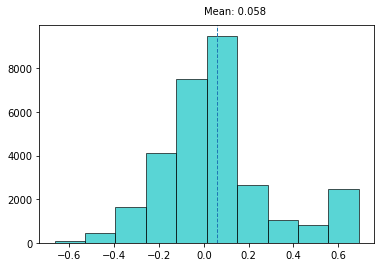

In [9]:
# plotting the results
def plot_histogram(values, mean_value):
    plt.hist(values, color="c", edgecolor="k", alpha=0.65)
    plt.axvline(mean_value, linestyle="dashed", linewidth=1)
    _, plot_height = plt.ylim()
    plt.text(0, plot_height * 1.05, "Mean: {:.3f}".format(mean_value))
    plt.show()


plot_histogram(per_sample_silhouettes, mean_silhouette)

## Part  4 - segment descriptions

In [10]:
# calculating popularity of beer styles in the whole population


def get_per_segment_styles_popularity(
    users_favourite_beers, beer_styles, segmentation, segments_count
):
    beer_styles_per_segment = {i: defaultdict(lambda: 0) for i in range(segments_count)}
    # we can call this dict by: beer_styles_per_segment[segment][style]

    for user, beers in users_favourite_beers.items():
        for beer in beers:
            beer_styles_per_segment[segmentation[user]][beer] += 1

    return beer_styles_per_segment


def get_total_styles_popularity(beer_styles_per_segment):
    total_popularity = defaultdict(lambda: 0)
    for user, beers in users_favourite_beers.items():
        for beer in beers:
            total_popularity[beer] += 1

    return total_popularity


per_segment_styles_popularity = get_per_segment_styles_popularity(
    users_favourite_beers, beer_styles, segmentation, SEGMENTS_COUNT
)
total_styles_popularity = get_total_styles_popularity(per_segment_styles_popularity)

In [11]:
# przygotujmy dwa opisy segmentow - top N najpopularniejszych stylow w kazdym segmencie
#   oraz top N unikalnych - to samo, ale popularnosc w segmencie dzielimy przez laczna popularnosc
#   dla potrzeb wizualizacji w nastepnym kroku, zwroc slownik {segment_id -> {style_id -> frequency}}


def most_popular_styles_per_segment(per_segment_styles_popularity, N):
    most_popular_styles = {}
    for segment, popularity in per_segment_styles_popularity.items():
        most_popular_styles[segment] = {
            beer_styles[x[0]]: x[1]
            for x in sorted(popularity.items(), key=lambda x: x[1], reverse=True)[:N]
        }
    return most_popular_styles


def most_distinctive_styles_per_segment(
    total_styles_popularity, per_segment_styles_popularity, N
):
    most_popular_styles = {}
    for segment, popularity in per_segment_styles_popularity.items():
        most_popular_styles[segment] = {
            beer_styles[x[0]]: x[1]
            for x in sorted(
                popularity.items(),
                key=lambda x: x[1] / total_styles_popularity[x[0]],
                reverse=True,
            )[:N]
        }
    return most_popular_styles


top_N = 50
most_popular = most_popular_styles_per_segment(per_segment_styles_popularity, top_N)
most_distinctive = most_distinctive_styles_per_segment(
    total_styles_popularity, per_segment_styles_popularity, top_N
)

In [12]:
def most_popular_styles_per_segment(per_segment_styles_popularity, N):
    most_popular_style = {}
    for segment, popularity in per_segment_styles_popularity.items():
        best = 0
        best_style = -1
        for style in popularity.keys():
            if popularity[style] > best:
                best = popularity[style]
                best_style = style
        most_popular_style[segment] = int(best_style)
    return most_popular_style


def most_distinctive_styles_per_segment(
    total_styles_popularity, per_segment_styles_popularity, N
):
    most_unique_style = {}
    for segment, popularity in per_segment_styles_popularity.items():
        best = 0
        best_style = -1
        for style in popularity.keys():
            if popularity[style] / total_styles_popularity[style] > best:
                best = popularity[style] / total_styles_popularity[style]
                best_style = style
        most_unique_style[segment] = int(best_style)
    return most_unique_style

##  Part 5 - visualization

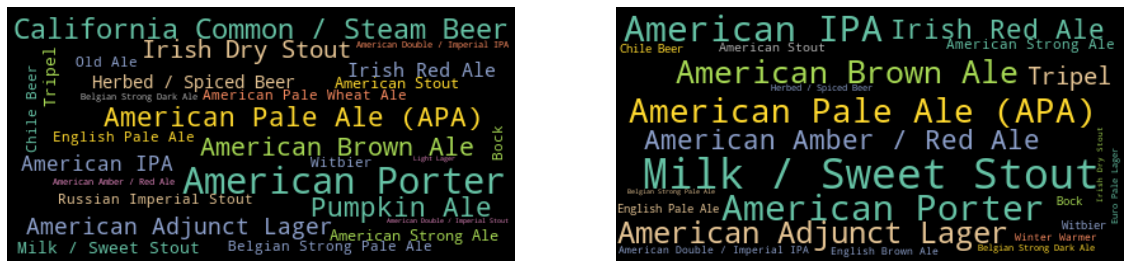

In [13]:
# we can visualize the segments to determine which beer is the most popular or unique in one cluster


def visualise_styles(most_popular, most_distinctive, segment_id):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    wordcloud1 = WordCloud(random_state=42, background_color="black", colormap="Set2")
    wordcloud1.generate_from_frequencies(frequencies=most_popular[segment_id])
    ax1.imshow(wordcloud1, interpolation="bilinear")
    wordcloud2 = WordCloud(random_state=42, background_color="black", colormap="Set2")
    wordcloud2.generate_from_frequencies(frequencies=most_distinctive[segment_id])
    ax2.imshow(wordcloud2, interpolation="bilinear")
    ax1.axis("off")
    ax2.axis("off")
    plt.show()


visualise_styles(most_popular, most_distinctive, 3)